In [1]:
import sys
import os
import glob
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from matplotlib import pyplot as plt
from nilearn.masking import apply_mask
sys.path.append('..')
from utils.data import load_participant_list

# Parameters

In [2]:
statistic = 'z_score'
multiple_comp_corr = 'fdr'
alpha = 0.05
run = 'test'
first_level_dir = '/Users/hugofluhr/data/LH_dev/nilearn/new_first_level_scrubbed_demeaned_basic_motion'

# Load First level data

In [3]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = '/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1'

dev_sub_ids = ['01', '02', '03', '04', '05', '06']
all_sub_ids = load_participant_list(base_dir)

sub_ids = all_sub_ids

### To do
fix the glob to get also non masked (some subjects have None mask so the filename is different)
only a problem for learning blocks

In [4]:
contrast_modulator_RL_paths = [
    glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}_run-{run}_model_rl*_masked_z_map.nii.gz"))[0]
    for sub_id in sub_ids
]
contrast_modulator_CK_paths = [
    glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}_run-{run}_model_ck*_masked_z_map.nii.gz"))[0]
    for sub_id in sub_ids
]

contrast_modulator_RL_paths.sort()
contrast_modulator_CK_paths.sort()

assert len(contrast_modulator_RL_paths) == len(sub_ids), "Some subjects are missing RL contrast maps."
assert len(contrast_modulator_CK_paths) == len(sub_ids), "Some subjects are missing CK contrast maps."

print("All subjects are present for both RL and CK.")

All subjects are present for both RL and CK.


In [5]:
contrast_modulator_RL_imgs = [image.load_img(path) for path in contrast_modulator_RL_paths]
contrast_modulator_CK_imgs = [image.load_img(path) for path in contrast_modulator_CK_paths]

## Load masks

In [6]:
mask_dir = '/Users/hugofluhr/data/LH_dev/masks'
vmpfc_mask_path = os.path.join(mask_dir, 'vmpfc_mask.nii.gz')
striatum_mask_path = os.path.join(mask_dir, 'striatum_mask.nii.gz')
putamen_mask_path = os.path.join(mask_dir, 'putamen_mask.nii.gz')
parietal_mask_path = os.path.join(mask_dir, 'parietal_mask.nii.gz')

# Q-value modulation

In [7]:
X_RL = pd.DataFrame([1] * len(contrast_modulator_RL_imgs), columns=['RL_value'])

In [8]:
second_level_model_RL = SecondLevelModel()
second_level_model_RL = second_level_model_RL.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

In [9]:
RL_WB_zmap = second_level_model_RL.compute_contrast(output_type=statistic)

## Whole brain

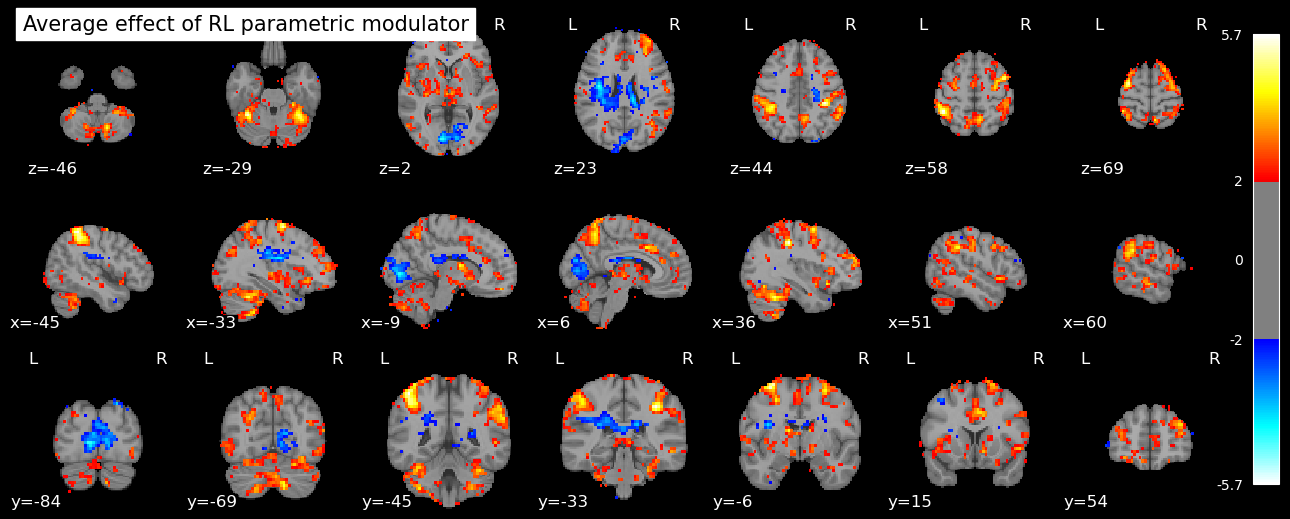

In [10]:
plot_stat_map(RL_WB_zmap, threshold=2, black_bg=True, display_mode='mosaic', title='Average effect of RL parametric modulator')


### Correct for multiple comparisons

In [11]:
RL_WB_thresholded_zmap, RL_WB_threshold = threshold_stats_img(RL_WB_zmap, alpha=alpha, height_control=multiple_comp_corr)
print(f"RL whole brain FDR threshold: {RL_WB_threshold:.3f}")

RL whole brain FDR threshold: 3.438


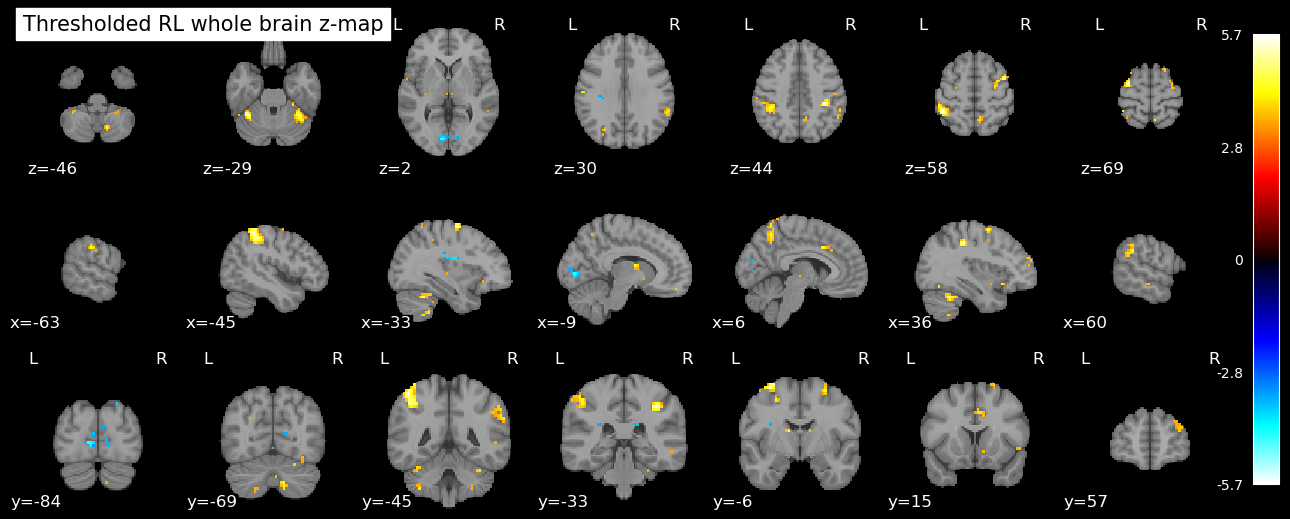

In [12]:
plot_stat_map(RL_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL whole brain z-map')

## ROIs for Q-values: VMPFC

In [13]:
vmpfc_mask = image.load_img(vmpfc_mask_path)
vmpfc_mask = image.resample_to_img(vmpfc_mask, RL_WB_zmap, interpolation='nearest')
vmpfc_masker = NiftiMasker(mask_img=vmpfc_mask)

In [14]:
vmpfc_second_level = SecondLevelModel(mask_img=vmpfc_masker)
vmpfc_second_level = vmpfc_second_level.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [15]:
RL_vmpfc_zmap = vmpfc_second_level.compute_contrast(output_type=statistic)

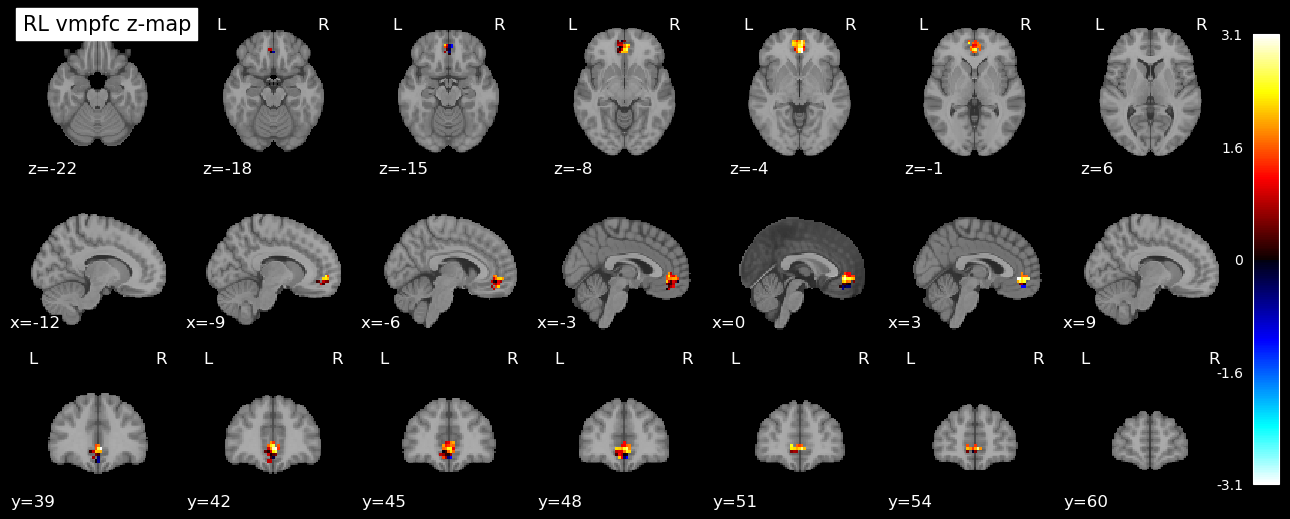

In [16]:
plot_stat_map(RL_vmpfc_zmap, black_bg=True, display_mode='mosaic', title='RL vmpfc z-map')

In [17]:
RL_vmpfc_thresholded_zmap, RL_vmpfc_threshold = threshold_stats_img(RL_vmpfc_zmap, alpha=0.001)#, height_control=multiple_comp_corr)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.147270077252607. But, you have given threshold=3.2905267314918945.
  stat_img = threshold_img(


/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


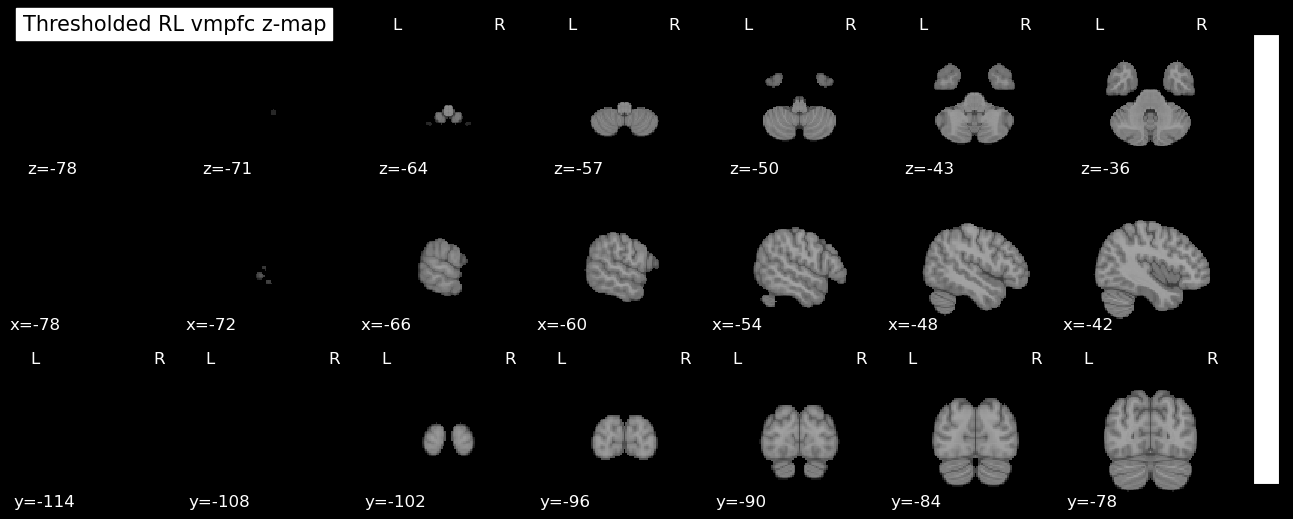

In [18]:
plot_stat_map(RL_vmpfc_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL vmpfc z-map')

In [19]:
vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 3.147270077252607. But, you have given threshold=3.2905267314918945.
  stat_img = threshold_img(
/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_37133/1815125761.py:1: UserWarning: Attention: No clusters with stat higher than 3.2905267314918945
  vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)
/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_37133/1815125761.py:1: UserWarning: Attention: No clusters with stat lower than -3.2905267314918945
  vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)


## ROIs for Q-values: Striatum

In [20]:
striatum_mask = image.load_img(striatum_mask_path)
striatum_mask = image.resample_to_img(striatum_mask, RL_WB_zmap, interpolation='nearest')
striatum_masker = NiftiMasker(mask_img=striatum_mask)

In [21]:
striatum_second_level = SecondLevelModel(mask_img=striatum_masker)
striatum_second_level = striatum_second_level.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [22]:
RL_striatum_zmap = striatum_second_level.compute_contrast(output_type=statistic)

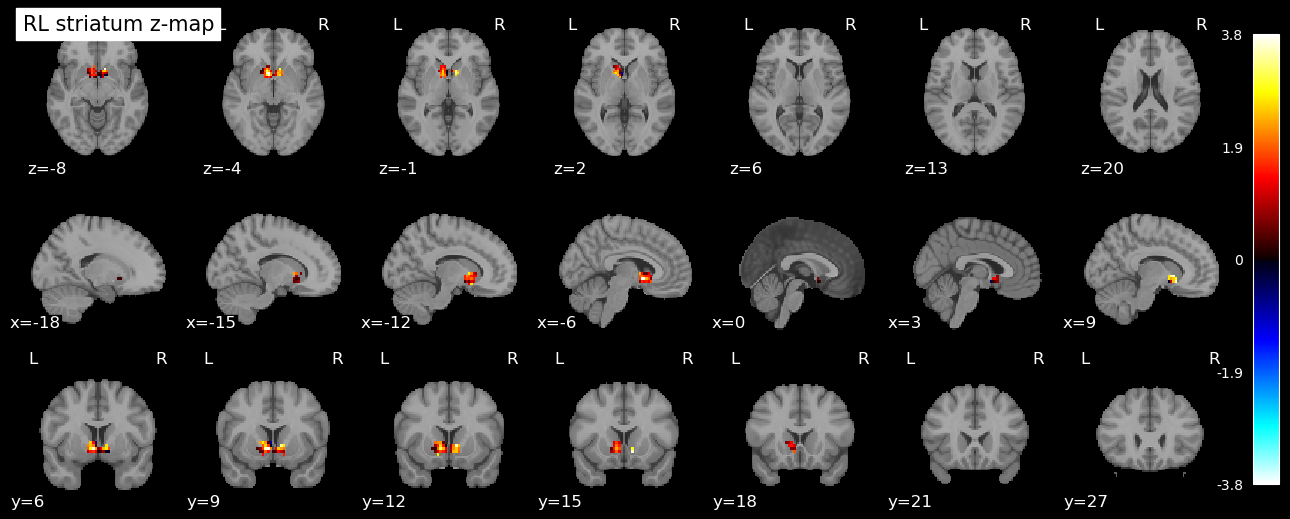

In [23]:
plot_stat_map(RL_striatum_zmap, black_bg=True, display_mode='mosaic', title='RL striatum z-map')

In [61]:
RL_striatum_thresholded_zmap, RL_striatum_threshold = threshold_stats_img(RL_striatum_zmap, alpha=alpha, height_control=multiple_comp_corr)
print(f"RL striatum FDR threshold: {RL_striatum_threshold:.3f}")

RL striatum FDR threshold: 3.128


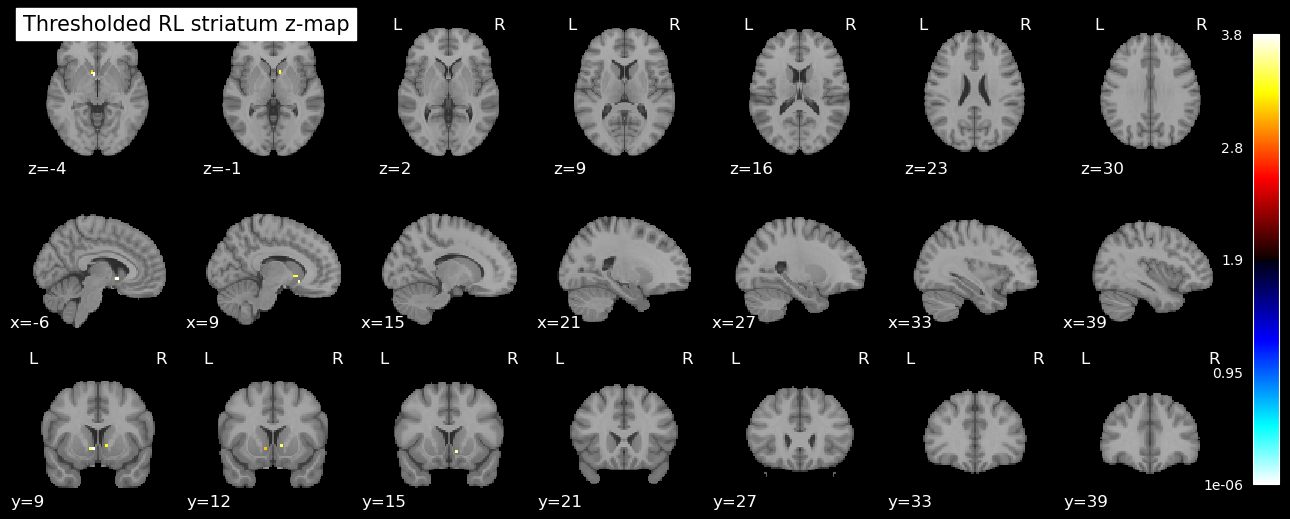

In [62]:
plot_stat_map(RL_striatum_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL striatum z-map')

In [65]:
striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold)#, two_sided=True)

In [66]:
striatum_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-6.0,9.0,-4.5,3.791373,126
1,2,9.0,15.0,-8.0,3.612097,31
2,3,9.0,12.0,-1.0,3.492911,63


# H-value modulation

In [28]:
X_CK = pd.DataFrame([1] * len(contrast_modulator_CK_imgs), columns=['CK_value'])

In [29]:
second_level_model_CK = SecondLevelModel()
second_level_model_CK = second_level_model_CK.fit(contrast_modulator_CK_imgs, design_matrix=X_RL)

In [30]:
CK_WB_zmap = second_level_model_CK.compute_contrast(output_type=statistic)

## Whole brain

In [31]:
np.corrcoef(CK_WB_zmap.get_fdata().flatten(), RL_WB_zmap.get_fdata().flatten())

array([[1.        , 0.60728796],
       [0.60728796, 1.        ]])

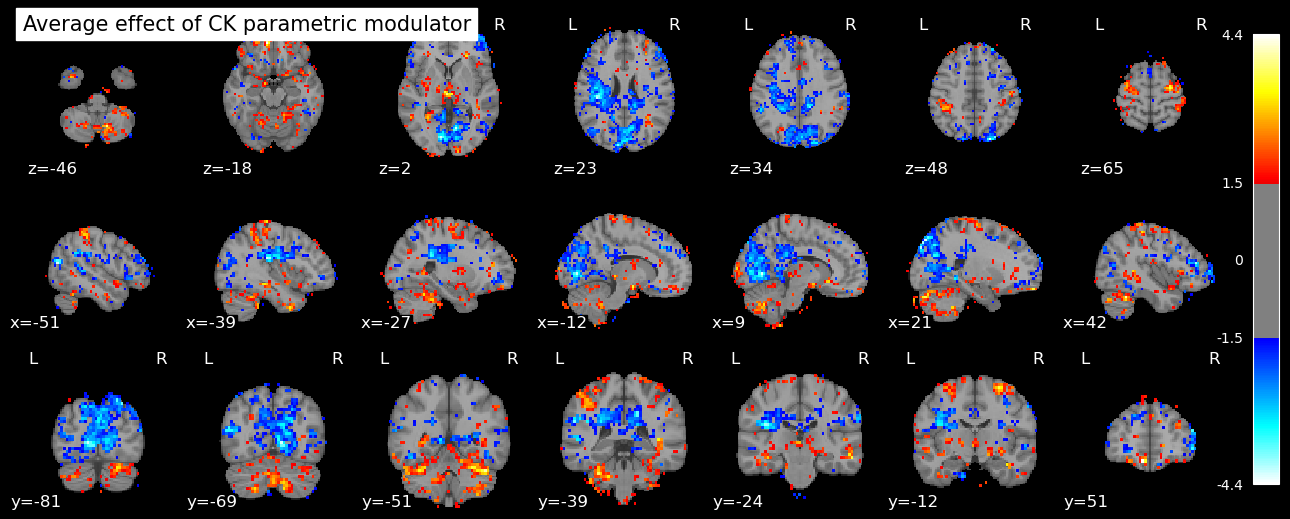

In [32]:
plot_stat_map(CK_WB_zmap, threshold=1.5, black_bg=True, display_mode='mosaic', title='Average effect of CK parametric modulator')


### Correct for multiple comparisons

In [69]:
CK_WB_thresholded_zmap, CK_WB_threshold = threshold_stats_img(CK_WB_zmap, alpha=0.001)#, height_control=multiple_comp_corr)
print(f"CK whole brain Bonferroni threshold: {CK_WB_threshold:.3f}")

CK whole brain Bonferroni threshold: 3.291


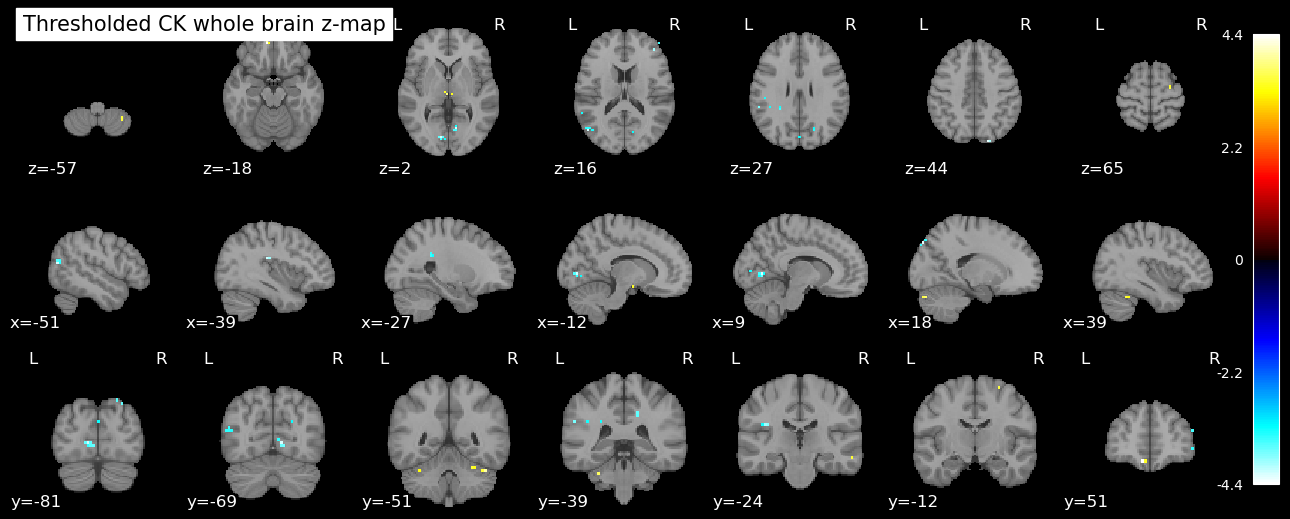

In [70]:
plot_stat_map(CK_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK whole brain z-map')

In [71]:
#get_clusters_table(CK_WB_thresholded_zmap, CK_WB_threshold, two_sided=True)

## ROIs for H-values: putamen

In [72]:
putamen_mask = image.load_img(putamen_mask_path)
putamen_mask = image.resample_to_img(putamen_mask, RL_WB_zmap, interpolation='nearest')
putamen_masker = NiftiMasker(mask_img=putamen_mask)

In [73]:
putamen_second_level = SecondLevelModel(mask_img=putamen_masker)
putamen_second_level = putamen_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [38]:
CK_putamen_zmap = putamen_second_level.compute_contrast(output_type=statistic)

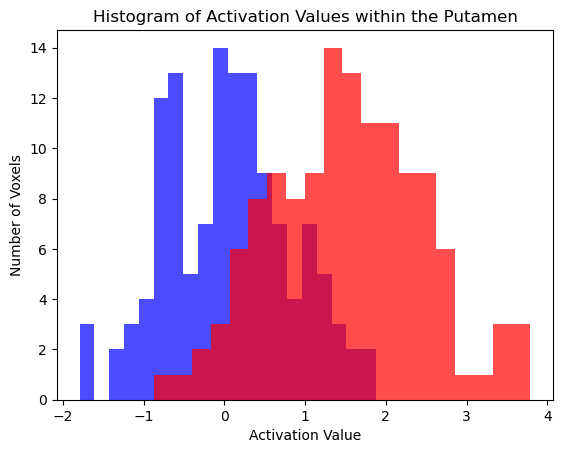

In [39]:
H_values_putamen = apply_mask(CK_WB_zmap, striatum_mask)
Q_values_putamen = apply_mask(RL_WB_zmap, striatum_mask)
plt.hist(H_values_putamen, bins=20, color='blue', alpha=0.7)
plt.hist(Q_values_putamen, bins=20, color='red', alpha=0.7)
plt.title('Histogram of Activation Values within the Putamen')
plt.xlabel('Activation Value')
plt.ylabel('Number of Voxels')
plt.show()

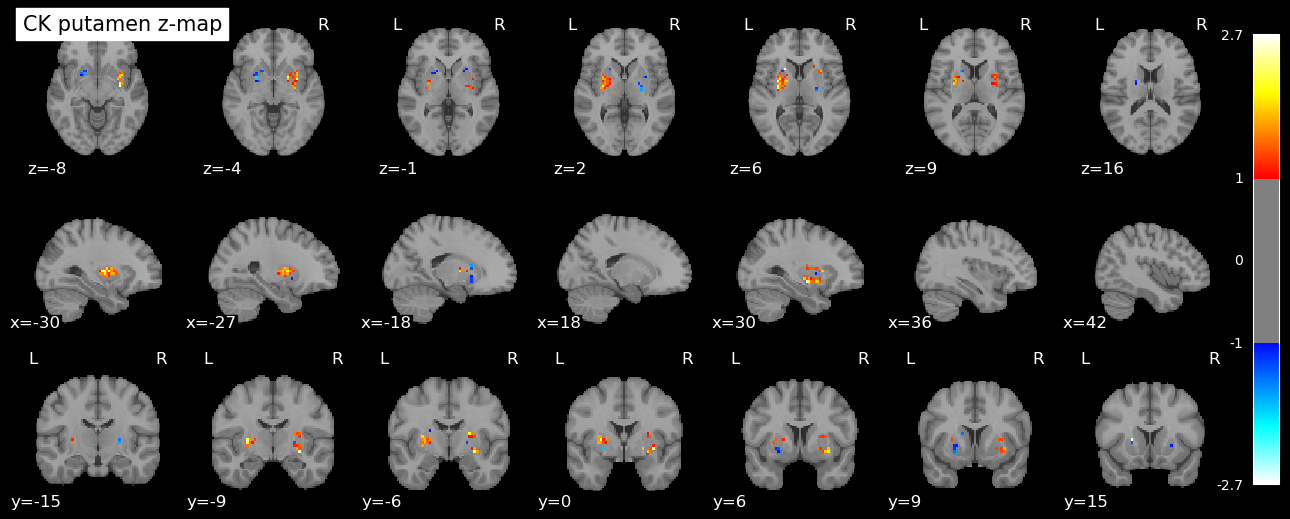

In [74]:
plot_stat_map(CK_putamen_zmap, threshold=1,black_bg=True, display_mode='mosaic', title='CK putamen z-map')

In [79]:
CK_putamen_thresholded_zmap, CK_putamen_threshold = threshold_stats_img(CK_putamen_zmap, alpha=alpha, height_control='fdr')

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.722029367570817. But, you have given threshold=inf.
  stat_img = threshold_img(


/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


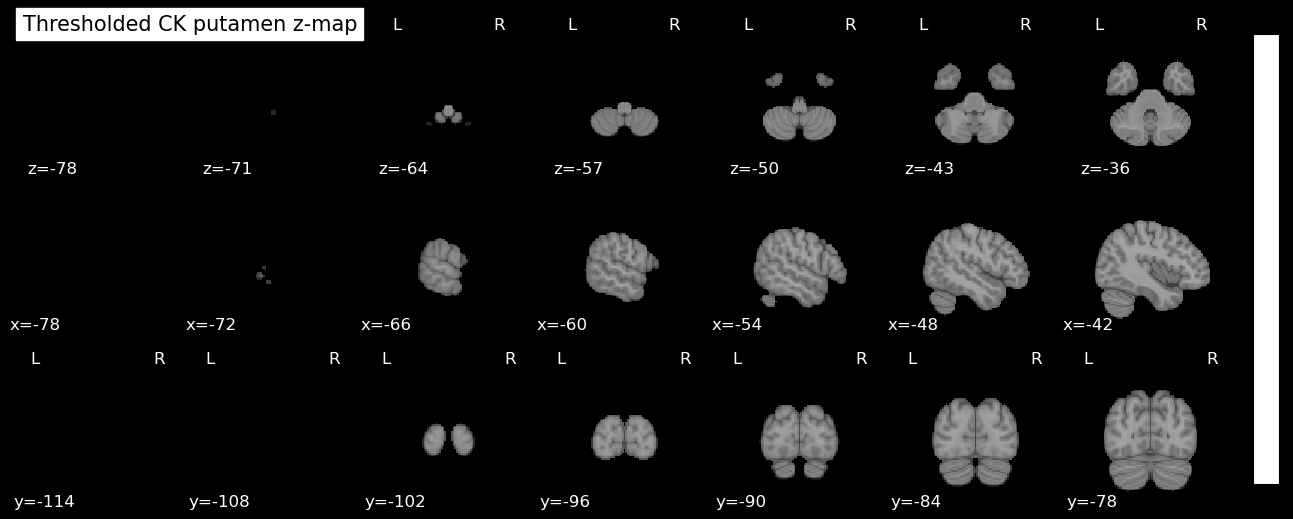

In [80]:
plot_stat_map(CK_putamen_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK putamen z-map')

In [43]:
putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)
putamen_table

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 2.722029367570817. But, you have given threshold=inf.
  stat_img = threshold_img(
/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_37133/2590643497.py:1: UserWarning: Attention: No clusters with stat higher than inf
  putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)
/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_37133/2590643497.py:1: UserWarning: Attention: No clusters with stat lower than -inf
  putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


## ROIs for H-values: parietal cortex

In [44]:
parietal_mask = image.load_img(parietal_mask_path)
parietal_mask = image.resample_to_img(parietal_mask, RL_WB_zmap, interpolation='nearest')
parietal_masker = NiftiMasker(mask_img=parietal_mask)

In [45]:
parietal_second_level = SecondLevelModel(mask_img=parietal_masker)
parietal_second_level = parietal_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [46]:
CK_parietal_zmap = parietal_second_level.compute_contrast(output_type=statistic)

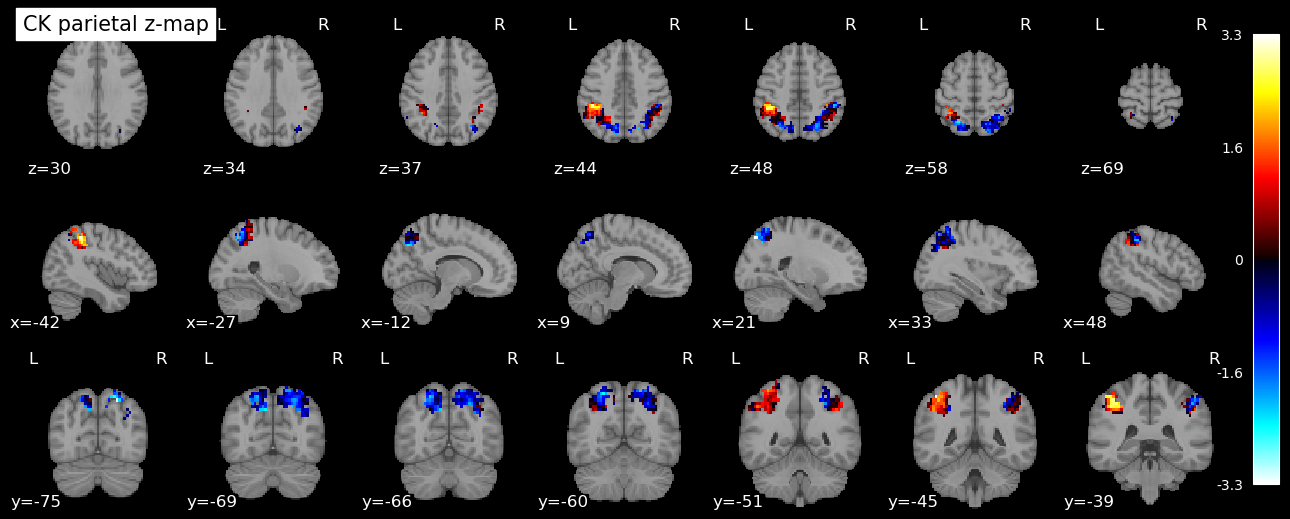

In [47]:
plot_stat_map(CK_parietal_zmap, black_bg=True, display_mode='mosaic', title='CK parietal z-map')

In [86]:
CK_parietal_thresholded_zmap, CK_parietal_threshold = threshold_stats_img(CK_parietal_zmap, alpha=alpha, height_control=multiple_comp_corr)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.253282216900187. But, you have given threshold=inf.
  stat_img = threshold_img(


/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


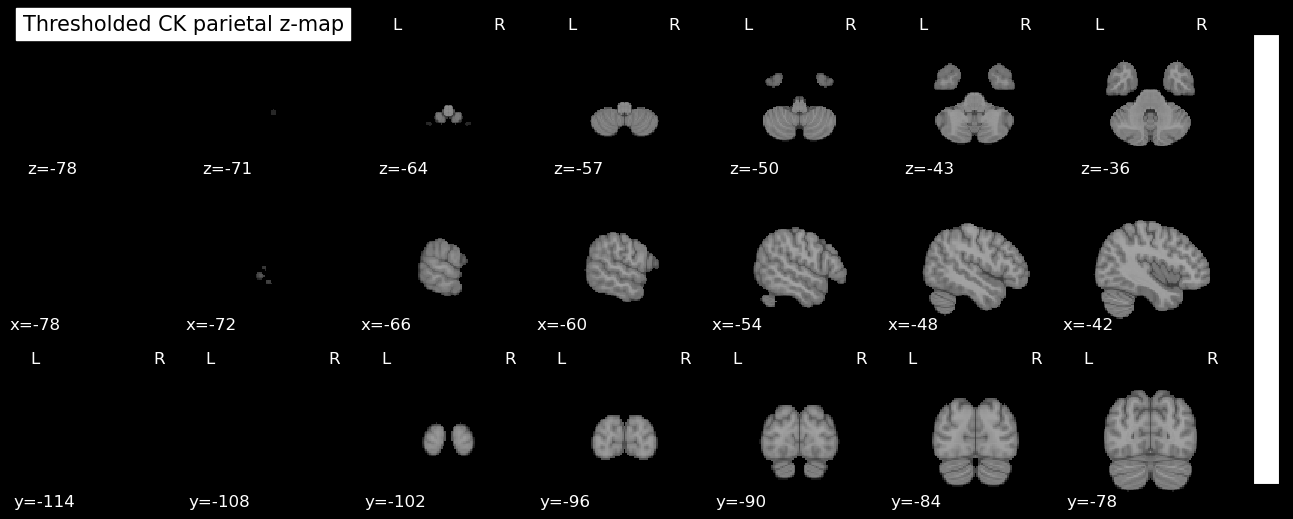

In [87]:
plot_stat_map(CK_parietal_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK parietal z-map')

In [50]:
parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 3.253282216900187. But, you have given threshold=inf.
  stat_img = threshold_img(
/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_37133/2125408686.py:1: UserWarning: Attention: No clusters with stat higher than inf
  parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)
/var/folders/zw/s9jkbctn3193dlc4s0nyk3440000gn/T/ipykernel_37133/2125408686.py:1: UserWarning: Attention: No clusters with stat lower than -inf
  parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)


# ROI results

In [51]:
combined_table

NameError: name 'combined_table' is not defined

In [ ]:
# Add ROI information to each table
vmpfc_table['ROI'] = 'VMPFC'
striatum_table['ROI'] = 'Striatum'
putamen_table['ROI'] = 'Putamen'
parietal_table['ROI'] = 'Parietal Cortex'

# Combine the tables
combined_table = pd.concat([vmpfc_table, striatum_table, putamen_table, parietal_table])
combined_table['Coordinates (MNI)'] = combined_table[['X', 'Y', 'Z']].apply(lambda row: tuple(row), axis=1)
combined_table = combined_table[['ROI', 'Cluster ID', 'Coordinates (MNI)', 'Cluster Size (mm3)', 'Peak Stat']]

# Filter out secondary peaks
combined_table = combined_table[~combined_table['Cluster ID'].str.contains('[a-zA-Z]', na=False)]

In [ ]:
voxel_volume = np.prod(np.abs(np.diag(RL_WB_zmap.affine)[:3]))
voxel_volume

In [ ]:
combined_table['Cluster Size (voxels)'] = np.round(combined_table['Cluster Size (mm3)'].astype('float') / voxel_volume).astype('int')
combined_table

In [ ]:
# to see number of voxels in each mask:
np.unique(vmpfc_mask.get_fdata(), return_counts=True)

In [ ]:
final_table = combined_table.copy()
final_table = final_table[final_table['Cluster Size (voxels)'] >= 10]
final_table

In [54]:
#final_table.to_csv('final_table.csv', index=False)

In [93]:
striatum_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),ROI,Coordinates (MNI)
0,1,-6.0,9.0,-4.5,3.791373,126,Striatum,"(-6.0, 9.0, -4.5)"
1,2,9.0,15.0,-8.0,3.612097,31,Striatum,"(9.0, 15.0, -8.0)"
2,3,9.0,12.0,-1.0,3.492911,63,Striatum,"(9.0, 12.0, -1.0)"


In [94]:
# Add ROI information to each table
striatum_table['ROI'] = 'Striatum'

# Combine the tables
combined_table = striatum_table
combined_table['Coordinates (MNI)'] = combined_table[['X', 'Y', 'Z']].apply(lambda row: tuple(row), axis=1)
combined_table = combined_table[['ROI', 'Cluster ID', 'Coordinates (MNI)', 'Cluster Size (mm3)', 'Peak Stat']]

# Filter out secondary peaks
#combined_table = combined_table[~combined_table['Cluster ID'].str.contains('[a-zA-Z]', na=False)]

In [95]:
combined_table

,ROI,Cluster ID,Coordinates (MNI),Cluster Size (mm3),Peak Stat
0,Striatum,1,"(-6.0, 9.0, -4.5)",126,3.791373
1,Striatum,2,"(9.0, 15.0, -8.0)",31,3.612097
2,Striatum,3,"(9.0, 12.0, -1.0)",63,3.492911
